In [1]:
import configparser
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import user_agents

%matplotlib inline
sns.set_style('whitegrid')

In [2]:
# get parameters
config = configparser.ConfigParser()
config.read_file(open('dwh.cfg'))

In [3]:
str_conn = "host={} dbname={} user={} password={} port={}".format(*config['CLUSTER'].values())
print(str_conn)

conn = psycopg2.connect(str_conn)
conn.set_session(autocommit=True)
cur = conn.cursor()

host=redshift-cluster-1.ct9nailhmb83.us-west-2.redshift.amazonaws.com dbname=dwh user=dwhuser password=Passw0rd port=5439


## General Statistics

In [4]:
def get_total(cur, objects):   
    totals = dict()
    for obj in objects:
        obj_id = "%s_id" % obj
        table = "%ss" % obj
        query = "SELECT COUNT(DISTINCT %s) FROM %s;" % (obj_id, table)
        cur.execute(query)
        res = cur.fetchone()
        totals[obj] = res[0]
    return totals

In [5]:
objects = ['songplay', 'user', 'artist', 'song']
totals = get_total(cur, objects)
for k, v in totals.items():
    print("Total {}s = {}".format(k, v))

Total songplays = 333
Total users = 97
Total artists = 9553
Total songs = 14896


## Analyses

In [6]:
def bar_plot(df, x, y, ix, iy, ax, **kwargs):
    sns.barplot(data=df, x=x, y=y, ax=ax);
    for p in ax.patches:
        ax.annotate('{}'.format(round(p.get_height())), (p.get_x() + ix, p.get_height() + iy))
    ax.set(**kwargs);

def pie_plot(df, x, y, ax, **kwargs):
    ax.pie(x=df[y], labels=df[x],
        autopct = "%.1f%%", explode = [0.05] * df.shape[0], pctdistance = 0.5
    );
    ax.set(**kwargs);

def plot_bar_pie_graphs(df, x, y, ix, iy, kwargs=[{}, {}], figsize=(16,8)):
    fig, axes = plt.subplots(1, 2, figsize = figsize)
    bar_plot(df, x, y, ix, iy, axes[0], **kwargs[0])
    pie_plot(df, x, y, axes[1], **kwargs[1])

def bar_plot_horizontal(df, x, y, ix, iy, ax, **kwargs):
    df[y] = df[y].astype(str)
    sns.barplot(data=df, x=x, y=y, ax=ax);
    for p in ax.patches:
        ax.annotate('{}'.format(round(p.get_width())), (p.get_width() + ix, p.get_y() + iy))
    ax.set(**kwargs);

#### Q1. Which user level is more active on Sparkify app?

In [7]:
query="""
SELECT level, count(songplay_id)
FROM songplays
GROUP BY level;
"""
cur.execute(query)
res = cur.fetchall()
df_level = pd.DataFrame(res)
df_level.columns = ['level', 'plays']
df_level.head()

,level,plays
0,paid,271
1,free,62


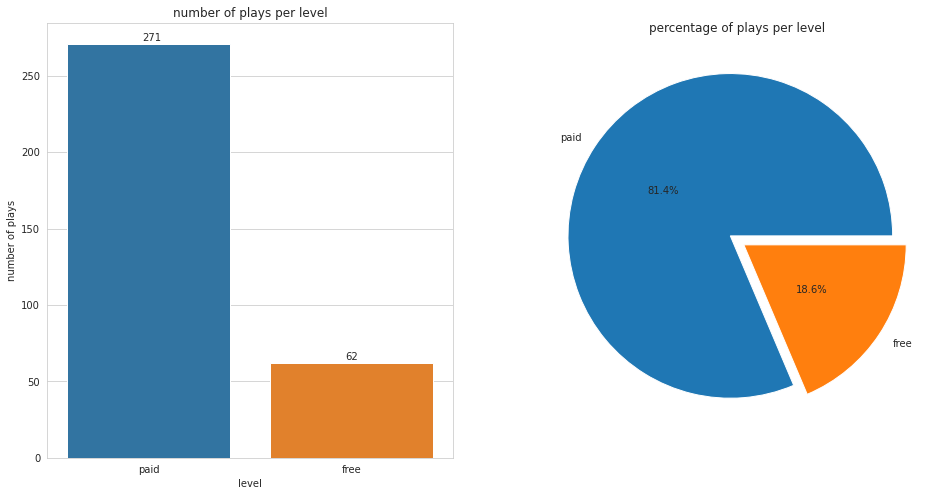

In [8]:
kwargs = [
    {'ylabel':'number of plays', 'title':'number of plays per level'},
    {'title':'percentage of plays per level'}
]
plot_bar_pie_graphs(df_level, 'level', 'plays', ix=0.37, iy=2, kwargs=kwargs)
plt.savefig('images/plays_per_level.png')

#### Q2. What is the rate of user levels?

In [9]:
query="""
SELECT level, count(user_id)
FROM users
GROUP BY level;
"""
cur.execute(query)
res = cur.fetchall()
df_user = pd.DataFrame(res)
df_user.columns = ['level', 'users']
df_user.head()

,level,users
0,free,75
1,paid,22


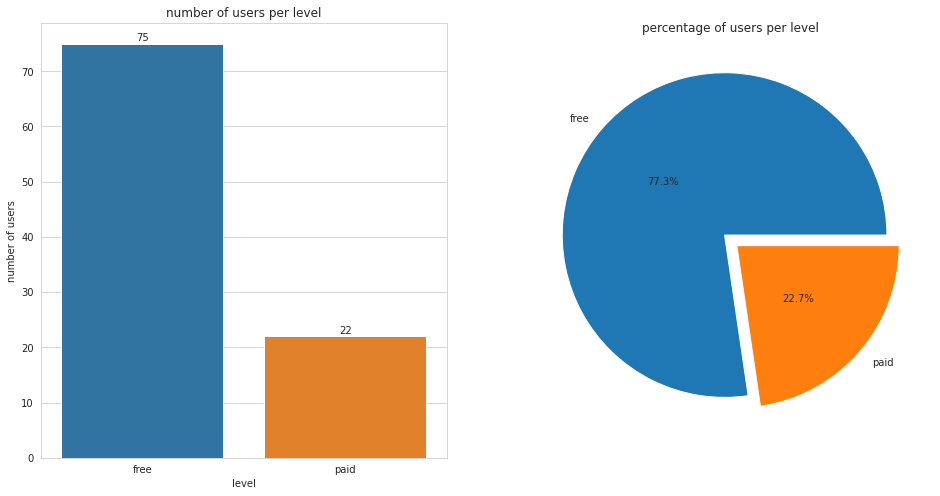

In [10]:
kwargs = [
    {'ylabel':'number of users', 'title':'number of users per level'},
    {'title':'percentage of users per level'}
]
plot_bar_pie_graphs(df_user, 'level', 'users', ix=0.37, iy=0.5, kwargs=kwargs)
plt.savefig('images/users_per_level.png')

#### Q3. Which browsers are used to access Sparkify app?

In [11]:
query="""
SELECT user_agent, count(songplay_id)
FROM songplays
GROUP BY user_agent;
"""
cur.execute(query)
res = cur.fetchall()
df_user_agent = pd.DataFrame(res)
df_user_agent.columns = ['user_agent', 'plays']

ugs = [user_agents.parse(i) for i in df_user_agent['user_agent']]
df_user_agent['browser'] = [ug.browser.family for ug in ugs]
df_browser = df_user_agent[['browser', 'plays']].groupby(['browser']).sum().reset_index()
df_browser.head()

,browser,plays
0,Chrome,171
1,Chromium,16
2,Firefox,88
3,IE,1
4,Mobile Safari,10


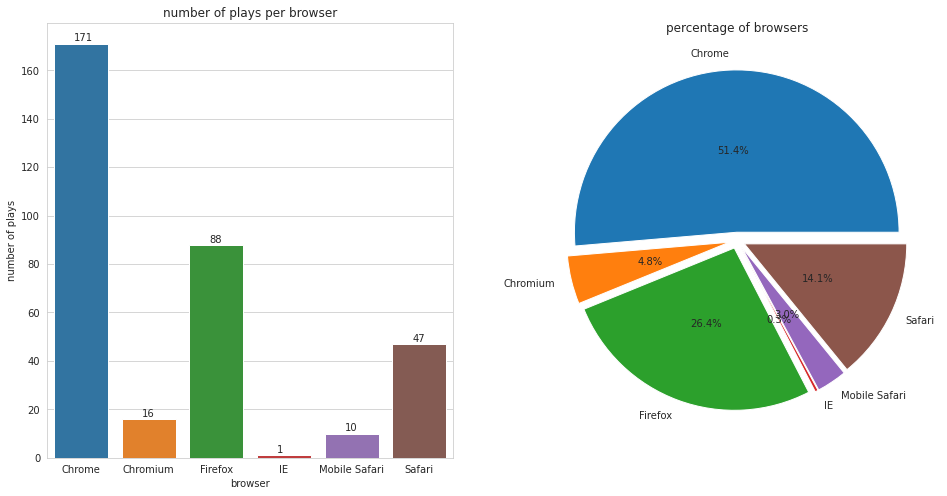

In [12]:
kwargs = [
    {'ylabel':'number of plays', 'title':'number of plays per browser'},
    {'title':'percentage of browsers'}
]
plot_bar_pie_graphs(df_browser, 'browser', 'plays', ix=0.3, iy=1, kwargs=kwargs)
plt.savefig('images/browser.png')

#### Q4. What is the rate of using Sparkify app over weeks?

In [13]:
query="""
SELECT week, count(songplay_id)
FROM songplays
JOIN time ON songplays.start_time = time.start_time
GROUP BY week
ORDER BY week;
"""
cur.execute(query)
res = cur.fetchall()
df_week = pd.DataFrame(res)
df_week.columns = ['week', 'plays']
df_week.head()

,week,plays
0,44,18
1,45,73
2,46,84
3,47,74
4,48,84


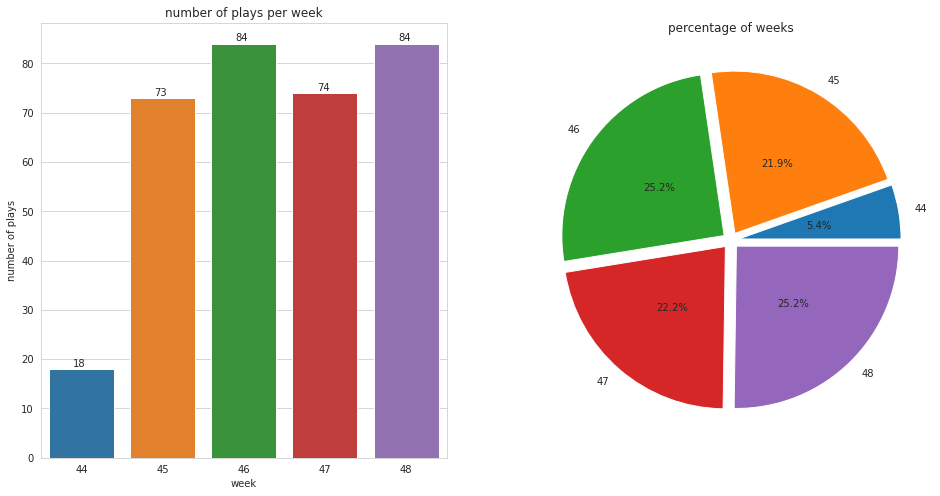

In [14]:
kwargs = [
    {'ylabel':'number of plays', 'title':'number of plays per week'},
    {'title':'percentage of weeks'}
]
plot_bar_pie_graphs(df_week, 'week', 'plays', ix=0.3, iy=0.5, kwargs=kwargs)
plt.savefig('images/week.png')

#### Q5. Top users, regions using Sparkify app

In [15]:
query="""
SELECT user_id, count(songplay_id) AS plays
FROM songplays
GROUP BY user_id
ORDER BY plays DESC
LIMIT 10;
"""
cur.execute(query)
res = cur.fetchall()
df_user = pd.DataFrame(res)
df_user.columns = ['user', 'plays']
df_user.head()

,user,plays
0,49,42
1,97,32
2,80,31
3,44,21
4,73,18


In [16]:
query="""
SELECT REVERSE(TRIM(SPLIT_PART(REVERSE(location), ',', 1))) AS region, count(songplay_id) AS plays
FROM songplays
GROUP BY region
ORDER BY plays DESC
LIMIT 10;
"""
cur.execute(query)
res = cur.fetchall()
df_region = pd.DataFrame(res)
df_region.columns = ['region', 'plays']
df_region.head()

,region,plays
0,CA,78
1,MI,34
2,ME,31
3,IA,21
4,FL,19


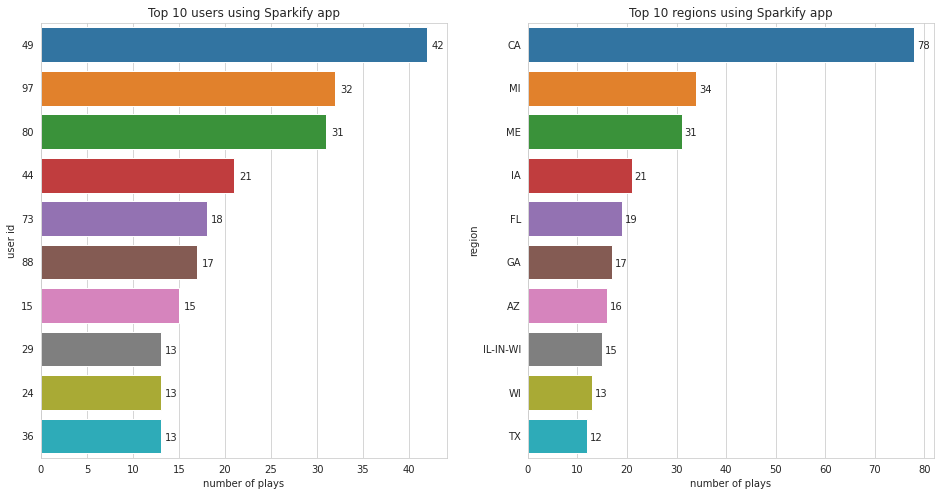

In [17]:
kwargs = [
    {'xlabel':'number of plays', 'title':'Top 10 users using Sparkify app', 'ylabel': 'user id'},
    {'xlabel':'number of plays', 'title':'Top 10 regions using Sparkify app'}
]
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
bar_plot_horizontal(df_user, 'plays', 'user', ix=0.5, iy=0.5, ax=axes[0], **kwargs[0])
bar_plot_horizontal(df_region, 'plays', 'region', ix=0.5, iy=0.5, ax=axes[1], **kwargs[1])
plt.savefig('images/top_users_regions.png')

In [18]:
cur.close()
conn.close()